In [1]:
import torch
# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

from botorch.test_functions import Ackley

# Test the 5D Ackley function
dim = 5
ackley_function = Ackley(dim=dim)

# Define the objective function
def objective_function(X):
    return ackley_function(2*X-1)

In [2]:
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
seed = 42
maximize = False
num_iterations = 30

In [5]:
from pandora_bayesopt.bayesianoptimizer import BayesianOptimizer
from botorch.utils.sampling import draw_sobol_samples
from botorch.acquisition.predictive_entropy_search import qPredictiveEntropySearch

In [12]:
draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1), seed=seed).squeeze(0)

tensor([[0.9975, 0.1044, 0.8230, 0.4194, 0.5283],
        [0.0562, 0.4553, 0.7492, 0.2211, 0.6177],
        [0.8101, 0.2123, 0.0384, 0.8818, 0.6506],
        [0.6666, 0.8209, 0.5966, 0.2363, 0.8070],
        [0.1671, 0.7678, 0.6035, 0.9326, 0.5377],
        [0.3988, 0.3613, 0.2897, 0.6536, 0.2348],
        [0.3760, 0.3226, 0.9922, 0.3485, 0.0177],
        [0.3184, 0.4282, 0.3828, 0.1698, 0.0865],
        [0.4084, 0.3584, 0.4702, 0.4870, 0.2529],
        [0.8249, 0.6175, 0.3714, 0.4692, 0.2109],
        [0.7513, 0.0865, 0.5580, 0.2718, 0.6343]])

In [4]:
torch.manual_seed(seed)

init_x = torch.rand(2*dim+1, dim)

# Create an instance of BayesianOptimizer
EI_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, initial_points=init_x, input_standardize=True)
# Run the optimization
EI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=ExpectedImprovement)
EI_best_history = EI_optimizer.get_best_history()

Acq value: tensor(0.0658)
Iteration 0, New point: [0.65987645 0.40513142 0.20696111 0.62105888 0.45819242], New value: 2.99835361125869
Best observed value: 2.9317472189307456
Cumulative cost: 1.0

Acq value: tensor(0.0388)
Iteration 1, New point: [0.66895769 0.50277357 0.         0.66236846 0.51040631], New value: 3.1038566138251764
Best observed value: 2.9317472189307456
Cumulative cost: 2.0

Acq value: tensor(0.0419)
Iteration 2, New point: [0.70449763 0.42072381 0.14537011 0.5139756  0.44444176], New value: 2.897562190913654
Best observed value: 2.897562190913654
Cumulative cost: 3.0

Acq value: tensor(0.0306)
Iteration 3, New point: [0.7152203  0.49082073 0.24769373 0.58747217 0.38670315], New value: 3.0304570456234257
Best observed value: 2.897562190913654
Cumulative cost: 4.0

Acq value: tensor(0.0339)
Iteration 4, New point: [0.69868366 0.39479487 0.21463847 0.49723456 0.55204817], New value: 2.919384309737794
Best observed value: 2.897562190913654
Cumulative cost: 5.0

Acq val

In [13]:
torch.manual_seed(seed)

init_x = torch.rand(2*dim+1, dim)

# Example usage with GittinsIndex
GIdecay_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, initial_points=init_x, input_standardize=True)
GIdecay_optimizer.run(num_iterations=num_iterations, acquisition_function_class=GittinsIndex, decay=True, alpha=128)
GIdecay_best_history = GIdecay_optimizer.get_best_history()

current lambda: 0.03291613450167866
Acq value: tensor(-2.8310)
Iteration 0, New point: [0.64978352 0.38573399 0.23354735 0.63168891 0.44504061], New value: 3.0413642259097817
Best observed value: 2.9317472189307456
Cumulative cost: 1.0

current lambda: 0.03291613450167866
Acq value: tensor(-2.9145)
Iteration 1, New point: [0.66303128 0.46936925 0.         0.63654448 0.55476716], New value: 3.062095489177516
Best observed value: 2.9317472189307456
Cumulative cost: 2.0

current lambda: 0.03291613450167866
Acq value: tensor(-2.9267)
Iteration 2, New point: [0.69866628 0.4125046  0.06812259 0.52710837 0.41801611], New value: 2.9759970549223707
Best observed value: 2.9317472189307456
Cumulative cost: 3.0

current lambda: 0.03291613450167866
Acq value: tensor(-2.9382)
Iteration 3, New point: [0.70346321 0.51126115 0.11732014 0.65989082 0.38813678], New value: 3.3504847713243326
Best observed value: 2.9317472189307456
Cumulative cost: 4.0

current lambda: 0.03291613450167866
Acq value: tensor

In [6]:
torch.manual_seed(seed)

init_x = torch.rand(2*dim+1, dim)

# Example usage with GittinsIndex
GIlmbda_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, initial_points=init_x, input_standardize=True)
GIlmbda_optimizer.run(num_iterations=num_iterations, acquisition_function_class=GittinsIndex, lmbda=0.0001)
GIlmbda_best_history = GIlmbda_optimizer.get_best_history()

Acq value: tensor(-2.1764)
Iteration 0, New point: [0.61848341 0.3604482  0.17978612 0.76497999 0.31654241], New value: 3.775857589096209
Best observed value: 2.9317472189307456
Cumulative cost: 1.0

Acq value: tensor(-2.2135)
Iteration 1, New point: [0.64377243 0.39369031 0.35571368 0.49670881 0.58555602], New value: 2.2967004253511516
Best observed value: 2.2967004253511516
Cumulative cost: 2.0

Acq value: tensor(-1.5478)
Iteration 2, New point: [0.62796295 0.62668933 0.51447339 0.55471274 0.68472278], New value: 2.415908199655871
Best observed value: 2.2967004253511516
Cumulative cost: 3.0

Acq value: tensor(-1.5100)
Iteration 3, New point: [0.58279518 0.40138654 0.22704821 0.54168869 0.82835676], New value: 3.2205276771732874
Best observed value: 2.2967004253511516
Cumulative cost: 4.0

Acq value: tensor(-1.5395)
Iteration 4, New point: [0.7089099  0.55949735 0.63565954 0.41801611 0.56508186], New value: 2.4799518882111546
Best observed value: 2.2967004253511516
Cumulative cost: 5.

Text(0.5, 1.0, 'Performance of EI vs Gittins on Ackley')

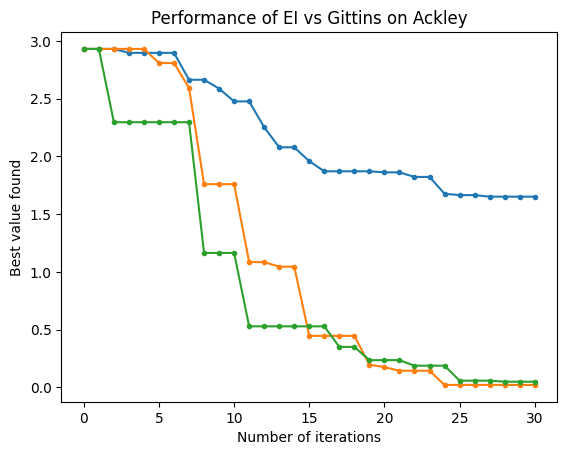

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(num_iterations+1), EI_best_history,'.-')
plt.plot(range(num_iterations+1), GIdecay_best_history,'.-')
plt.plot(range(num_iterations+1), GIlmbda_best_history,'.-')
plt.xlabel('Number of iterations')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins on Ackley")